### Install dependencies

In [1]:
%%capture --no-stderr
%pip install --quiet -U gradio networkx jinja2 langchain-core langchain-openai langgraph pydantic 

## Import Libraries

Set up API keys in a .env file

In [2]:
import copy
import operator
import uuid
from typing import (Annotated, Any, Dict, List, Optional, Set, Tuple, Type,
                    Union)

import gradio as gr
import networkx as nx
from IPython.display import Image
from jinja2 import Template
from langchain_core.messages import (AIMessage, ChatMessage, FunctionMessage,
                                     HumanMessage, SystemMessage, ToolMessage)
from langchain_core.runnables.config import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import Send
from langgraph.graph import MessagesState, StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field, PrivateAttr
from typing_extensions import TypedDict

/Users/marcosreyes/Documents/repos/hackthon/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define LLM model for the system. 

It must be LangChain compatible model.

It must support output parsing

In [3]:
# LLM model 
llm = ChatOpenAI(model="gpt-4o")

# Graph Inspector

## Utils

In [4]:
def create_structured_llm(config: dict, structured_output: BaseModel):
    try:
            model = config["configurable"].get("llm")
            structured_llm = model.with_structured_output(structured_output)
            return structured_llm
    except:
        raise ValueError("The llm model is not valid")

In [5]:
class PromtTemplate:
    """A class to render a prompt template with input variables."""
    def __init__(self, template: str, input_variables: list[str]):
        self.template = Template(template)
        self.input_variables = input_variables

    def render(self, **kwargs):
        return self.template.render(**kwargs)

In [6]:
class Config(TypedDict):
    user_id: uuid.uuid4
    thread_id: uuid.uuid4
    description: str

In [7]:
def invoke_graph(graph: CompiledGraph, 
                 input: Any,
                 thread_id:Optional[str] = None,
                 user_id:Optional[str]= None,
                 description:str="") -> tuple[Config, bool, str]:

    thread_id = thread_id if thread_id else str(uuid.uuid4())
    user_id = user_id if user_id else str(uuid.uuid4())
    
    config = Config(thread_id=thread_id,
                    user_id=user_id,
                    description=description)
    
    configurable = {"configurable": config}

    error = False
    error_message = ""

    try:
        graph.invoke(input, config=configurable, stream_mode="debug")
    except Exception as e:
        error_message = f"Graph execution failed: {e}"
        error = True

    return config, error, error_message

In [8]:
def reduce_valid_input(left: Any | None, right: Any | None) -> Any:
    if left is None:
        return right
    if right is None:
        return left
    if left == right:
        return left
    if left != right:
        return left

In [9]:
def generate_pairs(a: list, b: list) -> list[tuple]:
    result = []
    for node in a:
        for tester in b:
            result.append((node, tester))

    return result

In [10]:
# get the annotated type of an object

class TypeAnnotator:
    _iterables = [list, tuple, set, dict]
    _message_types = [HumanMessage, AIMessage, ToolMessage, SystemMessage, 
                     FunctionMessage, ChatMessage]
    _no_iterables = [int, float, str, bool] + _message_types

    def __init__(self, obj: Any):
        self.obj = obj

    def get_type(self) -> Type:
        """Get the type annotation directly as a typing object."""
        return self._infer_type(self.obj)

    def _infer_type(self, obj: Any) -> Type:
        """Recursively determine the type annotation of a complex structure."""
        # Handle message types first
        if any(isinstance(obj, t) for t in self._message_types):
            return type(obj)
        
        # Handle basic types
        if type(obj) in self._no_iterables:
            return type(obj)

        # Handle collections
        handlers = {
            list: self._handle_list,
            dict: self._handle_dict,
            tuple: self._handle_tuple,
            set: self._handle_set
        }
        return handlers.get(type(obj), lambda x: type(x))(obj)

    def _handle_list(self, obj: List) -> Type[List]:
        """Handle list type annotation."""
        if not obj:
            return List[Any]
        
        types = {self._infer_type(el) for el in obj}
        if len(types) == 1:
            return List[next(iter(types))]
        return List[Union[tuple(sorted(types, key=str))]]

    def _handle_dict(self, obj: Dict) -> Type[Dict]:
        """Handle dict type annotation."""
        if not obj:
            return Dict[Any, Any]
        
        key_types = {self._infer_type(k) for k in obj.keys()}
        value_types = {self._infer_type(v) for v in obj.values()}
        
        key_type = (Union[tuple(sorted(key_types, key=str))] 
                   if len(key_types) > 1 else next(iter(key_types)))
        value_type = (Union[tuple(sorted(value_types, key=str))] 
                     if len(value_types) > 1 else next(iter(value_types)))
        
        return Dict[key_type, value_type]

    def _handle_tuple(self, obj: Tuple) -> Type[Tuple]:
        """Handle tuple type annotation."""
        if not obj:
            return Tuple[()]
        return Tuple[tuple(self._infer_type(el) for el in obj)]

    def _handle_set(self, obj: Set) -> Type[Set]:
        """Handle set type annotation."""
        if not obj:
            return Set[Any]
        
        types = {self._infer_type(el) for el in obj}
        if len(types) == 1:
            return Set[next(iter(types))]
        return Set[Union[tuple(sorted(types, key=str))]]


In [11]:
# convert an object to a string representation

def obj_to_str(obj, max_depth=float('inf'), current_depth=0):
    """
    Converts any Python object into a string representation that looks like the original code.
    
    Args:
        obj: Any Python object
        max_depth: Maximum depth for recursion (default: infinite)
        current_depth: Current recursion depth (used internally)
        
    Returns:
        String representation of the object that looks like code
    """
    # Check if we've reached maximum depth
    if current_depth >= max_depth:
        return repr(obj)
    
    if isinstance(obj, dict):
        items = [f'"{k}": {obj_to_str(v, max_depth, current_depth + 1)}' for k, v in obj.items()]
        return '{' + ', '.join(items) + '}'
    elif isinstance(obj, (list, tuple)):
        items = [obj_to_str(item, max_depth, current_depth + 1) for item in obj]
        return '[' + ', '.join(items) + ']' if isinstance(obj, list) else '(' + ', '.join(items) + ')'
    elif isinstance(obj, str):
        return f'"{obj}"'
    elif isinstance(obj, (int, float, bool, type(None))):
        return str(obj)
    elif obj.__class__.__module__ == 'builtins':
        return repr(obj)
    else:
        # Handle custom objects by reconstructing their initialization
        class_name = obj.__class__.__name__
        
        # If at max_depth, just return the repr
        if current_depth >= max_depth:
            return f"{class_name}(...)"
        
        # Try to get the object's attributes
        try:
            # First try to get __dict__
            attrs = copy.copy(obj.__dict__)

            # more clear messages representation
            attrs.pop('additional_kwargs', None)
            attrs.pop('usage_metadata', None)
            attrs.pop('response_metadata', None)
            
        except AttributeError:
            try:
                # If no __dict__, try getting slots
                attrs = {slot: getattr(obj, slot) for slot in obj.__slots__}
            except AttributeError:
                # If neither works, just use repr
                return repr(obj)
        
        # Convert attributes to key=value pairs
        attr_strs = []
        for key, value in attrs.items():
            # Skip private attributes (starting with _)
            if not key.startswith('_'):
                attr_strs.append(f"{key}={obj_to_str(value, max_depth, current_depth + 1)}")
        
        return f"{class_name}({', '.join(attr_strs)})"

## Graph creation

### Pydantic/TypedDict  Models

In [12]:

class Node_description(BaseModel):
    node_description: str = Field(description="Description of the node. Max 45 words")
    # guesse_output: str = Field(description="What information would it pass to the next nodes?")

# ========================================
class SuggestedTester(BaseModel):
    role: str = Field(
        description="Role of the tester in the context of the graph.",
    )
    description: str = Field(
        description="Role description of the tester expertise, focus, concerns, and motives. (you are ...) ",
    )
    _id: str = PrivateAttr(default_factory=lambda: str(uuid.uuid4()))

    @property
    def id(self):
        return self._id
    
class Testers(BaseModel):
    testers: List[SuggestedTester] = Field(
        description="Comprehensive list of testers with their roles and descriptions",
    )

# ========================================
class TestCase(BaseModel):
    name: str = Field(description="name of the test case.")
    
    description: str = Field(description="Test case description")
    
    acceptance_criteria: str = Field(description="criteal to pass the test")
    
    tester_id: str = Field(description="leave this field blank", default='')

    _id: str = PrivateAttr(default_factory=lambda: str(uuid.uuid4()))

    @property
    def id(self):
        return self._id
    
class TaseCasesList(BaseModel):
    test_cases: List[TestCase] = Field(description="Comprehensive list of test cases with their properties")

# ========================================
class Input(BaseModel):
    new_input : str = Field(description="new input for the test case")
    tester_id: str = Field(description="leave this field blank", default='')
    test_case_id: str = Field(description="leave this field blank", default='')
    actual_input: Optional[Any] = Field(description="leave this field blank", default=None)
    is_successful: bool = Field(description="leave this field blank", default=False)

# ========================================
class FinalOutput(BaseModel):
    assertion : bool = Field(description="Assertion result of the test case")
    comments : str = Field(description="Comments on the test case output")
    tester_id: str = Field(description="leave this field blank", default='')
    test_case_id: str = Field(description="leave this field blank", default='')

# ========================================
    
class OverallState(TypedDict):
    # user input
    user_description: str
    valid_input: Annotated[Any, reduce_valid_input]
    graph_before_compile: StateGraph

    # internal use
    compiled_graph: Annotated[CompiledGraph, reduce_valid_input]
    summary_graph: nx.DiGraph
    execution_configs: Annotated[list[Config], operator.add]
    testers: dict[str, SuggestedTester]
    node_and_tester: list[tuple]
    test_cases: Annotated[list[TestCase], operator.add]
    all_new_inputs: Annotated[list[Input], operator.add]
    listResults: Annotated[list[FinalOutput], operator.add]

# ========================================
# subgraph to create new inputs

class SubGraphState(TypedDict):
    current_test_case: TestCase
    valid_input:  Annotated[Any, reduce_valid_input]
    all_new_inputs: Annotated[list[Input], operator.add]
    compiled_graph: Annotated[CompiledGraph, reduce_valid_input]
    execution_configs: Annotated[list[Config], operator.add]


Static test node

In [13]:
# nodes
def static_test(state: OverallState):
    memory = MemorySaver() # it could be a SQLite database
    graph_after_compile = state["graph_before_compile"].compile(checkpointer=memory)

    graph_object = graph_after_compile.get_graph()

    nodes = graph_object.nodes
    edges = graph_object.edges

    graph_sumary = nx.DiGraph()

    for name, node in nodes.items():
        tools = {}
        type_node = type(node.data)

        if type_node == ToolNode:
            for name_tool, tool in node.data.tools_by_name.items():
                tools[name_tool] = tool.description

        graph_sumary.add_node(name, type=type_node, runnable=node.data, tools=tools, name=name) 

    for edge in edges:
        graph_sumary.add_edge(edge.source, edge.target, conditional=edge.conditional)

    return {"compiled_graph": graph_after_compile,
             "summary_graph": graph_sumary,
             "execution_configs": []}

Generate node descriptions node

In [14]:
# Prompts 
node_description_promt = PromtTemplate(template="""
You are a workflow developer tasked with characterizating a graph. 
You have focused on LangChain and LangGraph frameworks in python.
Using the data below, describe what a node is for:

general graph description: {{graph_description}}

node name: {{node_name}}
type: {{type}}
{% if node_description %} previous description : {{node_description}} {% endif %}

income nodes: {{income_nodes}}
sample_input: {{input}}

outcome nodes: {{outcome_nodes}}
sample_output: {{output}}

{% if functions %}functions: {{functions}} {% endif %}

Take your time and be clrear.

First, identify the node name and its type.
Then look at the input_node, sample_input, and output_node, sample_output. 
Explain how it could interact with neighboring nodes.
Explain the input and output requirements.
{% if node_description %}Combine previous description and current description.{% endif %}
{% if functions %}figure out what the fuction are for in the graph context.{% endif %} 
Find out how the node can contribute to achieve the description. 
Finally, write the description of the node.""", 
input_variables=["graph_description", "input", "output", "node_name", "type", "functions", "income_nodes", "outcome_nodes", "node_description"])


# nodes
def generate_node_descriptions(state: OverallState, config: RunnableConfig):
    structured_llm = create_structured_llm(config, Node_description)

    config, error, error_message  = invoke_graph(graph=state["compiled_graph"],
                          input=state["valid_input"])
    
    if error:
        raise ValueError(f"Invalid graph input: {error}")
    
    configurable = {"configurable": config}

    history = list(state["compiled_graph"].get_state_history(configurable))
    history.reverse()

    node_name_in_tasks = [item.tasks[0].name for item in history if item.tasks]
    node_name_in_tasks.remove('__start__')
    
    node_tasks_in_tasks = [item.tasks[0].result for item in history if item.tasks]

    summary_graph = state["summary_graph"]

    for index, node_name in enumerate(node_name_in_tasks):
        current_description = summary_graph.nodes[node_name].get("description", None)
        functions = summary_graph.nodes[node_name].get("tools", None)

        actual_input = node_tasks_in_tasks[index]
        actual_output = node_tasks_in_tasks[index+1]

        parameters = {"graph_description":state["user_description"],
        "input":obj_to_str(actual_input),
        "output":obj_to_str(actual_output),
        "node_name":node_name,
        "type":str(summary_graph.nodes[node_name]["type"]),
        "functions":functions,
        "income_nodes":str(summary_graph.in_edges(node_name)),
        "outcome_nodes":str(summary_graph.out_edges(node_name)),
        "node_description":current_description}
                                                       
        system_message = node_description_promt.render(**parameters)
        llm_description = structured_llm.invoke([SystemMessage(system_message)])

        summary_graph.nodes[node_name]["description"] = llm_description.node_description

    
    return {"execution_configs": [config],
            "summary_graph": summary_graph}

Generate testers 

In [15]:
# promts
testers_instructions = PromtTemplate("""
You are tasked with creating a set of AI tester personas. 
Those are going to test an agentic system in python. 
Those must have a grasp of the LLM and LangGraph frameworks.
Follow these instructions carefully:
1. First, review the general graph description:
{{graph_description}}
        
2. Examine any security team feedback that has been optionally provided to guide creation of the testers: 
{{human_analyst_feedback}}
    
3. Determine the most critical kind of testing needed based upon the feedback above. Add more if needed.
Max number of analysts: {{max_analysts}}

5. Assign one tester to each theme. For each tester, provide the following information:""",
input_variables=["graph_description", "human_analyst_feedback", "max_analysts"])

# Nodes
def generate_testers(state: OverallState, config: RunnableConfig):
    structured_llm = create_structured_llm(config, Testers)
    
    parameters = {"graph_description":state["user_description"],
                    "human_analyst_feedback":"Include: functional tester, anti injection and jailbreak LLM engeener, vulnerabilities bounty hunter", 
                    "max_analysts":3}

    system_message = testers_instructions.render(**parameters)
    created_testers = structured_llm.invoke([SystemMessage(system_message)])

    nodes = [node_data for node_name, node_data in state["summary_graph"].nodes(data=True) if node_data.get("description", None)]
    testers = created_testers.testers
    
    return {"testers": {tester.id: tester for tester in created_testers.testers},
            "node_and_tester": generate_pairs(nodes, testers),
            "test_cases": []}

Generate test cases 

In [16]:
# promts
test_case_prompt = PromtTemplate("""
{{role_description}}

You must test this node deeply. The below is the node information:
                            
name: {{node_name}}
type: {{node_type}}
description: {{node_description}}
functions: {{node_functions}}
sample_input: {{sample_input}}
sample_output: {{sample_output}}
                               
existing test cases: {{existing_test_cases}}
                            
How would you test the node? 
Give at least 3 test case.
AVOID [repeating the same test case, puting values in the acceptance_criteria]                      
Take your time and think out of the box.
If there is no test case neded, return and empty object.""",
input_variables=["role_description", "node_name", "node_type", "node_description", "node_functions", "sample_input", "sample_output", "existing_test_cases"])

# Nodes
def generate_test_cases(state: OverallState, config: RunnableConfig):
    structured_llm = create_structured_llm(config, TaseCasesList)

    current_node_and_tester = state["node_and_tester"].pop(0)
    current_node = current_node_and_tester[0]
    current_tester = current_node_and_tester[1]

    configuration = state["execution_configs"][0]
    configurable = {"configurable": configuration}

    history = list(state["compiled_graph"].get_state_history(configurable))
    history.reverse()

    node_tasks_in_tasks = [(item.tasks[0].name, item.tasks[0].result) for item in history if item.tasks]

    actual_inputs = []
    actual_outputs = []

    for index, task in enumerate(node_tasks_in_tasks):
        if task[0] == current_node["name"]:
            actual_inputs.append(node_tasks_in_tasks[index-1][1])
            actual_outputs.append(task[1])

    name_test_cases = [test_case.name for test_case in state["test_cases"]]
    
    parameters = {"role_description":current_tester.description,
                  "node_name":current_node["name"],
                  "node_type":current_node["type"],
                  "node_description":current_node["description"],
                  "node_functions":current_node["tools"],
                  "sample_input":obj_to_str(actual_inputs),
                  "sample_output":obj_to_str(actual_outputs),
                  "existing_test_cases":name_test_cases}
    
    system_message = test_case_prompt.render(**parameters)
    test_cases = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of test cases.")])

    for test_case in test_cases.test_cases:
        test_case.tester_id = current_tester.id

    return {"test_cases": test_cases.test_cases}

# conditional edges
def more_test_cases(state: OverallState):
    if state["node_and_tester"]:
        return "generate_test_cases"
    else:
        routing = []
        valid_inpout = state["valid_input"]
        compiled_graph = state["compiled_graph"]
        execution_configs = state["execution_configs"]

        for test_case in state["test_cases"]:
            new_state = {"current_test_case":test_case, 
                         "valid_input":valid_inpout,
                         "compiled_graph":compiled_graph}
                    
            routing.append(Send("run_test_cases",new_state))

        return routing

Generate sub graph to create new inputs and run the tests

In [17]:
# Promts
new_input_prompt = PromtTemplate("""
You are a LangChain and LangGraph python developer. Your are focused on testing a graph of LangGraph.
Some senior testers have provided you with a test case for the graph.
The test case is as follows:
                                 
- name: {{test_case_name}}
- description: {{test_case_description}}
- graph valid input: {{graph_valid_input}}
                                 
you must follow this instructions:
1. Review the test case description.
2. Validate if the test case can be tested with an input using the valid input structure.
3. If it can't be tested, return an empty string.
4. If it can be tested, create a new imput for the test case.
5. verify carefully the new input format. Every open bracket must have a closing bracket and so on.
6. For each property in the input, you MUST make sure it is the same type as it is in valid input.
7. For any message object, the content must be a string.
8. Make sure the string could be passed to the 'eval' python function. For example, if the input has 'null' it should be 'None'.
9. Return the new input.""",
input_variables=["test_case_name", "test_case_description", "graph_valid_input"])

# Nodes
def generate_new_inputs(state: SubGraphState, config: RunnableConfig):
    structured_llm = create_structured_llm(config, Input)

    parameters = {"test_case_name": state["current_test_case"].name,
                  "test_case_description": state["current_test_case"].description,
                  "graph_valid_input": obj_to_str(state["valid_input"])}

    system_message = new_input_prompt.render(**parameters)

    new_input = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the new input.")])
    new_input.tester_id = state["current_test_case"].tester_id
    new_input.test_case_id = state["current_test_case"].id

    try:
        agent_valid_input = eval(new_input.new_input)
        agent_valid_input_type = TypeAnnotator(agent_valid_input).get_type()
        valid_input_type = TypeAnnotator(state["valid_input"]).get_type()

        if agent_valid_input_type == valid_input_type:
            new_input.actual_input = agent_valid_input

            config, error, error_message  = invoke_graph(graph=state["compiled_graph"],
                                                         input=agent_valid_input, 
                                                         description= state["current_test_case"].name,
                                                         thread_id=new_input.test_case_id,
                                                         user_id=new_input.tester_id)
            new_input.is_successful = not error
            
            return {"all_new_inputs": [new_input], 
                    "execution_configs": [config]}
        else:
            raise ValueError(f"invalid input type for {new_input.new_input}")

    except Exception as e:
        return {"all_new_inputs": []}

# Build the sub graph
sub_builder = StateGraph(SubGraphState)

sub_builder.add_node("generate_new_inputs", generate_new_inputs)

sub_builder.set_entry_point("generate_new_inputs")
sub_builder.set_finish_point("generate_new_inputs")

Anilize the results

In [18]:
# promts
assertion_prompt = PromtTemplate("""
{{role_description}}
A test cases has been run on the graph and here you have the results. 
You must validate the results using the test case description, acceptance criteria, and the output of the test case: 
                                 
- test case name: {{test_case_name}}
- test case description: {{test_case_description}}
- acceptance criteria: {{acceptance_criteria}}
- output: {{output}}
                                 
You must validate the output. If the output is as described in the acceptance criteria, return 'True'. Otherwise, return 'False'.
Finally, write additional comments of how to solve the issue if the output is not as expected.
If the output is as expected, the comments should be a description of the behavior of the graph.
""", input_variables=["test_case_name" ,"role_description", "test_case_description", "acceptance_criteria", "output"])

# Nodes
def analize_results(state: OverallState, config: RunnableConfig):
    structured_llm = create_structured_llm(config, FinalOutput)

    current_result_config = state["execution_configs"].pop(0)

    if not current_result_config["description"]:
        return {"listResults": []}
    
    for test_case in state["test_cases"]:
        if test_case.id == current_result_config["thread_id"]:
            current_test_case = test_case
            break  

    tester = state["testers"][current_result_config["user_id"]] 

    configurable = {"configurable": current_result_config}

    parameters = {"test_case_name" : current_test_case.name,
                  "role_description":tester.description,
                  "test_case_description":current_test_case.description,
                  "acceptance_criteria":current_test_case.acceptance_criteria,
                  "output":obj_to_str(state["compiled_graph"].get_state(configurable).values)}

    system_message = assertion_prompt.render(**parameters)
    final_output = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the final output.")])
    final_output.tester_id = tester.id
    final_output.test_case_id = current_test_case.id

    return {"listResults": [final_output]}

# conditional edges
def more_results(state: OverallState):
    return bool(state["execution_configs"])

In [19]:
builder = StateGraph(OverallState)

builder.add_node("static_test", static_test)
builder.add_node("generate_node_descriptions", generate_node_descriptions)
builder.add_node("generate_testers", generate_testers)
builder.add_node("generate_test_cases", generate_test_cases)
builder.add_node("run_test_cases", sub_builder.compile())
builder.add_node("analize_results", analize_results)


builder.set_entry_point("static_test")
builder.add_edge("static_test", "generate_node_descriptions")
builder.add_edge("generate_node_descriptions", "generate_testers")
builder.add_edge("generate_testers", "generate_test_cases")
builder.add_conditional_edges("generate_test_cases", more_test_cases, ["generate_test_cases", "run_test_cases"])
builder.add_edge("run_test_cases", "analize_results")
builder.add_conditional_edges("analize_results", more_results, {True: "analize_results", False: "__end__"})

graph = builder.compile()

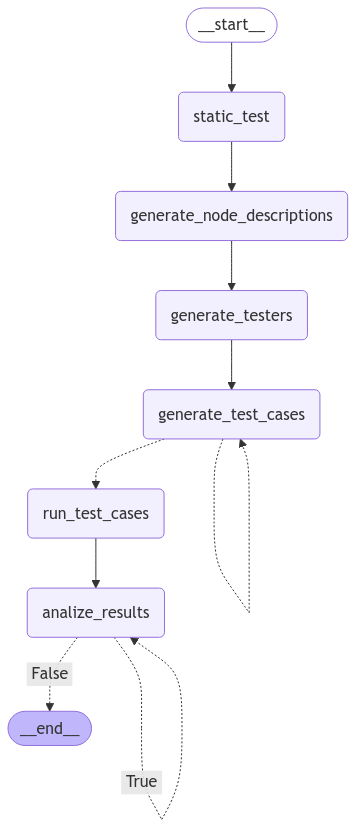

In [20]:
# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Simple graph for testing

In [21]:
# Tools
def multiply(a: float, b: float) -> float:
    """Multiply a and b.

    Args:
        a: first float
        b: second float
    """
    return a * b

def add(a: float, b: float) -> float:
    """Adds a and b.

    Args:
        a: first float
        b: second float
    """
    return a + b

def divide(a: float, b: float) -> float:
    """Divides a by b.

    Args:
        a: first float
        b: second float
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder_sample = StateGraph(MessagesState)

builder_sample.add_node("assistant", assistant)
builder_sample.add_node("tools", ToolNode(tools))


builder_sample.set_entry_point("assistant")
builder_sample.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder_sample.add_edge("tools", "assistant")

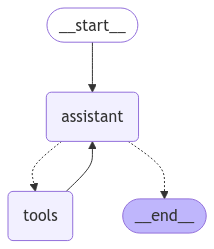

In [22]:
# View
display(Image(builder_sample.compile().get_graph(xray=True).draw_mermaid_png()))

## User input

In [23]:
user_description = "This is a react graph. It has one agent and one tool node. The agent is an assistant that can perform arithmetic operations."

user_valid_input = {"messages": [HumanMessage(content="Add 3 and 4")]}

graph_before_compile = builder_sample

In [26]:
configurations = {"configurable": {"llm": llm}, "recursion_limit": 50}

result = graph.invoke({"user_description":user_description
                       ,"valid_input": user_valid_input, 
                       "graph_before_compile": graph_before_compile},
                       config=configurations)

## Display results

In [27]:
# Define Unicode symbols for checkmark and cross
CHECKMARK = "\u2705"  # ✅
CROSS = "\u274C"      # ❌

with gr.Blocks() as demo:
    for result_graph in result["listResults"]:
        symbol = CHECKMARK if result_graph.assertion else CROSS

        for test_case in result["test_cases"]:
            if test_case.id == result_graph.test_case_id:
                current_test_case = test_case
                break

        tester = result["testers"][result_graph.tester_id] 

        configurations = {"configurable": {"user_id":tester.id, 
                                           "thread_id":current_test_case.id}}

        with gr.Accordion(f"{current_test_case.name}: {symbol}", open=False):
            gr.Markdown(f"{result_graph.comments}")

            with gr.Accordion(f"Details", open=False):
                gr.Markdown(f"Tester: {tester.role}")
                gr.Markdown(f"Teste description: {current_test_case.description}")
                gr.Markdown(f"Teste assertion: {current_test_case.acceptance_criteria}")
                gr.Markdown(f"Actual output: {obj_to_str(result["compiled_graph"].get_state(configurations).values)}")

demo.launch(debug=False, inbrowser=False)

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
